## Simple XGBoost tutorial


We will use the trivial **Iris Dataset** which you can get from directly from sklearn or from the UCI repository.

First of all, let's import what is needed:

In [5]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'xgboost'

Load the Iris dataset and split in train and test following the thumb rule of 80/20:

In [27]:
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
import Daniele.Utils.MyDataManager as dm
import Daniele.Utils.MatrixManipulation as mm
import Daniele.Utils.SaveSparceMatrix as ssm

URMv = dm.getURMviews()
URMo = dm.getURMopen()
ICMt = dm.getICMt()
ICMl = dm.getICMl()

URMv_train, URMv_test = split_train_in_two_percentage_global_sample(URMv, train_percentage = 0.80)

urm_def = mm.defaultExplicitURM(urmv=URMv_train,urmo=URMo,icml=ICMl,icmt=ICMt, normalize=True, add_aug=True,appendICM=True)

/Users/daniele/Desktop/RecSys/RecSysChallenge2023-Team


ModuleNotFoundError: No module named 'similaripy'

Use **DMatrix** as data structures for both train and test. 

DMatrix is a internal data structure that used by XGBoost which is optimized for both memory efficiency and training speed.
You can construct DMatrix from numpy.arrays:

In [ ]:
dtrain = xgb.DMatrix(URMv_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

Set XGBoost parameters:

merror: Multiclass classification error rate. It is calculated as #(wrong cases)/#(all cases).

In [ ]:
params = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # step for each iteration
    'silent': 1, # keep it quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3, # the number of classes 
    'eval_metric': 'merror'} # evaluation metric 

num_round = 20  # the number of training iterations (number of trees)

Create a model and fit it with params:

(We could have used also XGBClassifier, which is a scikit-learn compatible class. It is basically just a wrapper over the xgb.train function).

In [ ]:
model = xgb.train(params,
                  dtrain,
                  num_round,
                  verbose_eval=2,
                  evals=[(dtrain, 'train')])

[0]	train-merror:0.016667
[2]	train-merror:0.016667
[4]	train-merror:0.016667
[6]	train-merror:0.016667
[8]	train-merror:0.016667
[10]	train-merror:0.016667
[12]	train-merror:0.016667
[14]	train-merror:0.016667
[16]	train-merror:0.016667
[18]	train-merror:0.008333
[19]	train-merror:0.008333


In [ ]:
from sklearn.metrics import precision_score

preds = model.predict(dtest)
best_preds = np.asarray([np.argmax(line) for line in preds])
print("Precision: {:.2f} %".format(precision_score(y_test, best_preds, average='macro')))

Precision: 0.95 %


It is possible to show with an histogram the importance of each feature:

In [ ]:
%matplotlib inline
from xgboost import plot_importance

**Gain:** it implies the relative contribution of the corresponding feature to the model calculated by taking each feature's contribution for each tree in the model. A higher value of this metric when compared to another feature implies it is more important for generating a prediction.

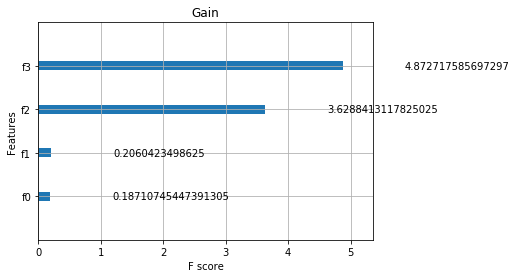

In [ ]:
plot_importance(model, importance_type='gain', title='Gain')

**Cover:** The Cover metric means the relative number of observations related to this feature. Therefore is the number of observations for which the leaf node is determined by the feature. This number will be calculated for all the features in the dataset and the cover will be expressed as a percentage over all features' cover metrics.

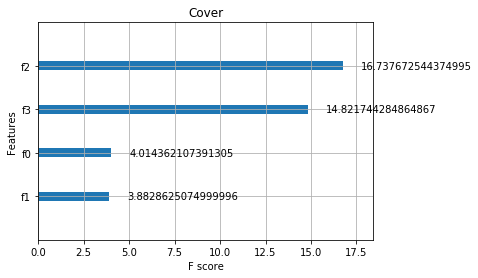

In [ ]:
plot_importance(model, importance_type='cover', title='Cover')

**Weight (Frequence):** is the percentage representing the relative number of times a particular feature occurs in the trees of the model. Is the number of splits in which the particular feature occurred.

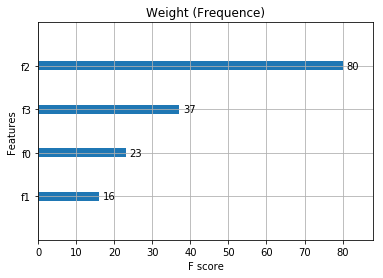

In [ ]:
plot_importance(model, importance_type='weight', title='Weight (Frequence)')

In order to avoid overfitting, we can use the early stopping technique looking at the error on our local validation set. Let's try it:

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=3)

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [ ]:
model = xgb.train(params,
                  dtrain,
                  num_round,
                  verbose_eval=2,
                  evals=[(dtrain, 'train'), (dval, 'validation')],
                  early_stopping_rounds=20)

[0]	train-merror:0.020833	validation-merror:0
Multiple eval metrics have been passed: 'validation-merror' will be used for early stopping.

Will train until validation-merror hasn't improved in 20 rounds.
[2]	train-merror:0.020833	validation-merror:0
[4]	train-merror:0.020833	validation-merror:0
[6]	train-merror:0.010417	validation-merror:0.041667
[8]	train-merror:0.010417	validation-merror:0.041667
[10]	train-merror:0	validation-merror:0.083333
[12]	train-merror:0	validation-merror:0.041667
[14]	train-merror:0	validation-merror:0.083333
[16]	train-merror:0	validation-merror:0.083333
[18]	train-merror:0	validation-merror:0.083333
[19]	train-merror:0	validation-merror:0.083333


### If we plot the precision and feature weight we may see changes in the values

In [ ]:
preds = model.predict(dtest)
best_preds = np.asarray([np.argmax(line) for line in preds])
print("Precision: {:.2f} %".format(precision_score(y_test, best_preds, average='macro')))

Precision: 0.95 %


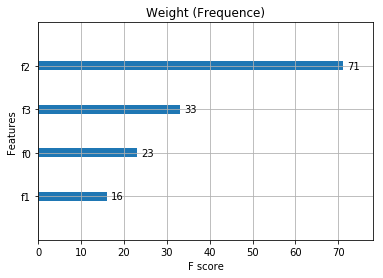

In [ ]:
plot_importance(model, importance_type='weight', title='Weight (Frequence)')

## How to use XGBoost in RecSys?

## Hint: reranking and hybridization

### Steps:
* Run your best algorithm and select a number of recommendations higher than the target cutoff, for example if you have to compute MAP@10, get 20 recommendations
* Build a dataframe whose samples are the user-item recommendations
* Add for each interaction some content features: item features, user features
* Add for each interaction some features derived by other algorithms: CBF prediction, hybrid prediction
* Add for each interaction other miscellaneous information: profile length, item popularity ..

## Dummy example

In [49]:
import os 
import sys
while os.path.split(os.getcwd())[1] != 'RecSysChallenge2023-Team':
    os.chdir('..')
sys.path.insert(1, os.getcwd())

In [50]:
path_save= "Daniele/Recommenders/XGBoot/saved_models"
if not os.path.exists(path_save):
    os.makedirs(path_save)

In [51]:
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Evaluation.Evaluator import EvaluatorHoldout

import Daniele.Utils.MyDataManager as dm 
import Daniele.Utils.MatrixManipulation as mm
import Daniele.Utils.SaveSparceMatrix as ssm

URMv = dm.getURMviews()
URMo = dm.getURMopen()
ICMt=dm.getICMt()
ICMl=dm.getICMl()

name="train.csv"
dir = os.path.join(path_save,name)
if not os.path.exists(dir):
    URMv_train, URMv_test = split_train_in_two_percentage_global_sample(URMv, train_percentage = 0.80)

    ssm.saveMatrix(dir,URMv_train)

    name="test.csv"
    dir = os.path.join(path_save,name)
    ssm.saveMatrix(dir,URMv_test)

    urm_def = mm.defaultExplicitURM(urmv=URMv_train,urmo=URMo,icml=ICMl,icmt=ICMt, normalize=True, add_aug=True,appendICM=True)
    name="urm_def.csv"
    dir = os.path.join(path_save,name)
    ssm.saveMatrix(dir,urm_def)

    urm_bin = mm.defaultExplicitURM(urmv=URMv_train,urmo=URMo, normalize=False, add_aug=True)
    urm_bin.data = np.ones(len(urm_bin.data))
    name="urm_bin.csv"
    dir = os.path.join(path_save,name)
    ssm.saveMatrix(dir,urm_bin)

else:
    URMv_train=ssm.readMatrix(dir)

    name="test.csv"
    dir = os.path.join(path_save,name)
    URMv_test=ssm.readMatrix(dir)

    name="urm_def.csv"
    dir = os.path.join(path_save,name)
    urm_def = ssm.readMatrix(dir)

    name="urm_bin.csv"
    dir = os.path.join(path_save,name)
    urm_bin = ssm.readMatrix(dir)


100%|██████████| 663370/663370 [00:01<00:00, 604442.17it/s]


In [52]:
################################# IMPORT RECOMMENDERS #################################

from Recommenders.BaseSimilarityMatrixRecommender import BaseItemSimilarityMatrixRecommender
from Daniele.Recommenders.KNN_CFCBF.ItemKNN_CFCBF_Hybrid_Recommender import KNN_CFCBF_custom
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.NonPersonalizedRecommender import TopPop

################################## IMPORT LIBRARIES ##################################

import pandas as pd
from numpy import linalg as LA
import Daniele.Utils.MatrixManipulation as mm 
import scipy.sparse as sps
from tqdm import tqdm
import numpy as np


#################################### HYBRID CLASS ####################################
class SSLIMRP3BetaKNNRecommender(BaseItemSimilarityMatrixRecommender):
    RECOMMENDER_NAME = "RP3BetaKNNRecommender"


    def __init__(self, urmv,urmo,icmt,icml):
        
        self.urmv = mm.explicitURM(urmv,slope=0.01, n_remove=2750, shrink_bias=85,bias='item', new_val = 0)
        self.urmo = mm.explicitURM(urmo, slope=0.01, n_remove = 10000, shrink_bias = 25,bias='user', new_val = 30)
        self.ICM_type = mm.augmentedICM(icmt,icml)

        urm = mm.defaultExplicitURM(urmv=urmv,urmo=urmo, normalize=False, add_aug=True)
        urm.data = np.ones(len(urm.data))
        self.urm_bin = urm

        self.urm_def = mm.defaultExplicitURM(urmv=urmv,urmo=urmo,icml=icml,icmt=icmt, normalize=True, add_aug=True,appendICM=True)

        self.interactions_threshold = 21
        super().__init__(self.urm_bin)

    def fit(self, alpha_knn_rp3=0.3,
            
            topK_rp3beta= 89, alpha_rp3beta =0.6361002951626124, beta_rp3beta= 0.27432996564004203, normalize_similarity_rp3beta= True,
            topK_knn= 744, shrink_knn= 457, similarity_knn= 'cosine', normalize_knn= True, feature_weighting_knn='TF-IDF',
            topK_sslim= 305, epochs_sslim=25,symmetric_sslim=True, sgd_mode_sslim = 'adam', lambda_i_sslim = 0.00048157278406027107, lambda_j_sslim=0.0002827394953195856, learning_rate_sslim = 0.009845463659115065,
            peso_1=0.6,peso_2=0.4,interactions_threshold =12

            ):
        self.peso_1 = peso_1
        self.peso_2 = peso_2
        self.interactions_threshold = interactions_threshold

        self.rp3beta_recommender = RP3betaRecommender(self.urm_bin)
        self.KNN_recommender = KNN_CFCBF_custom(self.urmv,self.urmo,ICM_train=self.ICM_type)
        self.sslim_recommender = SLIM_BPR_Cython(URM_train=self.urm_def)
        self.knn_rp3_recommender = ItemKNNCustomSimilarityRecommender(self.urm_def)
        self.most_viewed = TopPop(self.urm_bin)

        self.most_viewed.fit()
        # {'topK': 89, 'alpha': 0.6361002951626124, 'beta': 0.27432996564004203, 'normalize_similarity': True} -> opt_top
        self.rp3beta_recommender.fit(topK= topK_rp3beta, alpha= alpha_rp3beta, beta= beta_rp3beta, normalize_similarity= normalize_similarity_rp3beta)
        
        # {'topK': 744, 'shrink': 457, 'similarity': 'cosine', 'normalize': True, 'feature_weighting': 'TF-IDF'} -> opt_top
        self.KNN_recommender.fit(topK= topK_knn, shrink= shrink_knn, similarity= similarity_knn, normalize= normalize_knn, feature_weighting=feature_weighting_knn)

        # {'topK': 305, 'epochs': 25, 'symmetric': True, 'sgd_mode': 'adam', 'lambda_i': 0.0008132913041259862, 'lambda_j': 0.004889521240194745, 'learning_rate': 0.005381553515814384}
        # {'topK': 109, 'epochs': 25, 'symmetric': True, 'sgd_mode': 'adam', 'lambda_i': 0.00048157278406027107, 'lambda_j': 0.0002827394953195856, 'learning_rate': 0.009845463659115065}
        self.sslim_recommender.fit(topK= topK_sslim, epochs=epochs_sslim,symmetric=symmetric_sslim, sgd_mode = sgd_mode_sslim, lambda_i = lambda_i_sslim, lambda_j=lambda_j_sslim, learning_rate = learning_rate_sslim)

        # alpha =0.3
        self.knn_rp3_recommender.fit((1 - alpha_knn_rp3) * self.KNN_recommender.W_sparse + alpha_knn_rp3* self.rp3beta_recommender.W_sparse)

    def _compute_item_score(self,
                            user_id_array,
                            items_to_compute=None
                            ):


        item_weights = np.empty([len(user_id_array), self.urm_def.shape[1]])
        for i in range(len(user_id_array)):

            interactions = len(self.urmv[user_id_array[i],:].indices)

            if interactions >= 22:  # -> g.14
            
                w1 = self.rp3beta_recommender._compute_item_score([user_id_array[i]])
                #w1 = w1 / np.linalg.norm(w1, 2)
                item_weights[i,:] = w1 

            elif interactions >= 15: # -> g. 10

                w1 = self.knn_rp3_recommender._compute_item_score([user_id_array[i]])
                item_weights[i,:] = w1

            elif interactions >= self.interactions_threshold: #12 -> g. 7 
            
                
                #KNN-RP3Beta-SSLIM 
                w1 = self.knn_rp3_recommender._compute_item_score([user_id_array[i]])
                w1 = w1 / np.linalg.norm(w1, 2)

                w2 = self.sslim_recommender._compute_item_score([user_id_array[i]])
                w2 = w2 / np.linalg.norm(w2, 2)
                item_weights[i,:] = w1*self.peso_1+w2*self.peso_2

                
                """
                RP3Beta-KNN
                w1 = self.rp3beta_recommender._compute_item_score([user_id_array[i]])
                w1 = w1 / np.linalg.norm(w1, 2)

                w2 = self.KNN_recommender._compute_item_score([user_id_array[i]])
                w2 = w2 / np.linalg.norm(w2, 2)
                item_weights[i,:] = w1*self.peso_1+w2*self.peso_2
                """
                #w1 = self.knn_rp3_recommender._compute_item_score([user_id_array[i]])
                #item_weights[i,:] = w1
                
                

            elif interactions >= 1:
            
                w1 = self.sslim_recommender._compute_item_score([user_id_array[i]])
                item_weights[i,:] = w1 

            else:
                print("topPop")
                w1 = self.most_viewed._compute_item_score([user_id_array[i]])
                item_weights[i,:] = w1 

        return item_weights


In [53]:
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
name="sslim01"
dir = os.path.join(path_save,name)

sslim_recommender = SLIM_BPR_Cython(URM_train=urm_def)
if not os.path.exists(dir+".zip"):
    #{'topK': 51, 'epochs': 15, 'symmetric': True, 'sgd_mode': 'adam', 'lambda_i': 1e-05, 'lambda_j': 0.003215687724797301, 'learning_rate': 0.007114410195895492}
    sslim_recommender.fit(topK= 51, epochs=15,symmetric=True, sgd_mode = 'adam', lambda_i = 1e-05, lambda_j=0.003215687724797301, learning_rate = 0.007114410195895492)
    sslim_recommender.save_model(path_save,name)
else:
    sslim_recommender.load_model(path_save,name)

   

SLIM_BPR_Recommender: URM Detected 2 ( 0.0%) users with no interactions.
Deallocating Cython objects
Unable to read memory status: list index out of range
SLIM_BPR_Recommender: Automatic selection of fastest train mode. Unable to get current RAM status, you may be using a non-Linux operating system. Using dense matrix.


/bin/sh: free: command not found


Processed 70388 (100.0%) in 4.23 sec. BPR loss is 1.39E+00. Sample per second: 16610
SLIM_BPR_Recommender: Epoch 1 of 15. Elapsed time 3.38 sec
Processed 70388 (100.0%) in 3.08 sec. BPR loss is 4.75E+00. Sample per second: 22802
SLIM_BPR_Recommender: Epoch 2 of 15. Elapsed time 6.21 sec
Processed 70388 (100.0%) in 0.87 sec. BPR loss is 7.92E+00. Sample per second: 80738
SLIM_BPR_Recommender: Epoch 3 of 15. Elapsed time 6.99 sec
Processed 70388 (100.0%) in 1.34 sec. BPR loss is 1.12E+01. Sample per second: 52509
SLIM_BPR_Recommender: Epoch 4 of 15. Elapsed time 7.46 sec
Processed 70388 (100.0%) in 0.65 sec. BPR loss is 1.36E+01. Sample per second: 108291
SLIM_BPR_Recommender: Epoch 5 of 15. Elapsed time 7.77 sec
Processed 70388 (100.0%) in 0.82 sec. BPR loss is 1.74E+01. Sample per second: 85797
SLIM_BPR_Recommender: Epoch 6 of 15. Elapsed time 7.94 sec
Processed 70388 (100.0%) in 0.97 sec. BPR loss is 2.05E+01. Sample per second: 72705
SLIM_BPR_Recommender: Epoch 7 of 15. Elapsed time 

### KNN_CFCBF 

In [54]:
from Daniele.Recommenders.KNN_CFCBF.ItemKNN_CFCBF_Hybrid_Recommender import KNN_CFCBF_custom
name="knn_cfcbf"
dir = os.path.join(path_save,name)

KNN_recommender = KNN_CFCBF_custom(URMv_train,URMo,ICM_train=mm.augmentedICM(ICMt,ICMl))
if not os.path.exists(dir+".zip"):
    KNN_recommender.fit(topK= 744, shrink= 457, similarity= 'cosine', normalize= True, feature_weighting='TF-IDF')
    KNN_recommender.save_model(path_save,name)
else:
    KNN_recommender.load_model(path_save,name)

KNN_CFCBF_custom: URM Detected 3461 (12.4%) items with no interactions.
Beta-> 1.0 	ICM_weight-> 1.0
Similarity column 27968 (100.0%), 2217.13 column/sec. Elapsed time 12.61 sec
KNN_CFCBF_custom: Saving model in file 'Daniele/Recommenders/XGBoot/saved_modelsknn_cfcbf'
KNN_CFCBF_custom: Saving complete


### RP3Beta 


In [55]:
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
name="rp3beta"
dir = os.path.join(path_save,name)


rp3beta_recommender = RP3betaRecommender(urm_bin)
if not os.path.exists(dir+".zip"):
    rp3beta_recommender.fit(topK= 89, alpha= 0.6361002951626124, beta= 0.27432996564004203, normalize_similarity= True)
    rp3beta_recommender.save_model(path_save,name)
else:
    rp3beta_recommender.load_model(path_save,name)

RP3betaRecommender: URM Detected 3461 (12.4%) items with no interactions.
RP3betaRecommender: Similarity column 27968 (100.0%), 3137.57 column/sec. Elapsed time 8.91 sec
RP3betaRecommender: Saving model in file 'Daniele/Recommenders/XGBoot/saved_modelsrp3beta'
RP3betaRecommender: Saving complete


### RP3Beta - KNN_CFCBF

In [56]:
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender
alpha_knn_rp3 = 0.7
name="rp3beta-knn"
dir = os.path.join(path_save,name)


knn_rp3_recommender = ItemKNNCustomSimilarityRecommender(urm_def)
if not os.path.exists(dir+".zip"):
    knn_rp3_recommender.fit((1 - alpha_knn_rp3) * KNN_recommender.W_sparse + alpha_knn_rp3* rp3beta_recommender.W_sparse)
    knn_rp3_recommender.save_model(path_save,name)
else:
    knn_rp3_recommender.load_model(path_save,name)

ItemKNNCustomSimilarityRecommender: URM Detected 2 ( 0.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: Saving model in file 'Daniele/Recommenders/XGBoot/saved_modelsrp3beta-knn'
ItemKNNCustomSimilarityRecommender: Saving complete


### TopPop

In [57]:
from Recommenders.NonPersonalizedRecommender import TopPop
name="TopPop"
dir = os.path.join(path_save,name)

most_viewed = TopPop(urm_bin)
if not os.path.exists(dir+".zip"):
    most_viewed.fit()
    most_viewed.save_model(path_save,name)
else:
    most_viewed.load_model(path_save,name)

TopPopRecommender: URM Detected 3461 (12.4%) items with no interactions.
TopPopRecommender: Saving model in file 'Daniele/Recommenders/XGBoot/saved_modelsTopPop'
TopPopRecommender: Saving complete


### REFERENCE RP3Beta 0.052

In [58]:
best_reference = RP3betaRecommender(urm_bin)
#{'topK': 106, 'alpha': 0.6155817289031643, 'beta': 0.33427474623540737, 'normalize_similarity': True} -> MAP 0.0276355
best_reference.fit(topK= 106, alpha= 0.6155817289031643, beta= 0.33427474623540737, normalize_similarity= True)


RP3betaRecommender: URM Detected 3461 (12.4%) items with no interactions.
RP3betaRecommender: Similarity column 27968 (100.0%), 3069.50 column/sec. Elapsed time 9.11 sec


### Hybrid

In [59]:
from Daniele.Recommenders.Hybrid_KNN_RP3Beta_SSLIM.hybrid import SSLIMRP3BetaKNNRecommender

hybrid = SSLIMRP3BetaKNNRecommender(URMv_train,URMo,ICMt,ICMl)
hybrid.rp3beta_recommender = rp3beta_recommender
hybrid.KNN_recommender = KNN_recommender
hybrid.sslim_recommender = sslim_recommender
hybrid.knn_rp3_recommender = knn_rp3_recommender
hybrid.most_viewed = most_viewed

# {'peso_1': 0.06475010925251191, 'peso_2': 0.027199820509343116, 'interactions_threshold': 7}
hybrid.peso_1=0.06475010925251191
hybrid.peso_2=0.027199820509343116
hybrid.interactions_threshold =7

100%|██████████| 663370/663370 [00:00<00:00, 969142.26it/s]


RP3BetaKNNRecommender: URM Detected 3461 (12.4%) items with no interactions.


## Build the dataframe with the predictions



In [66]:
import numpy as np
cutoff = 10
user_recommendations_items = []
user_recommendations_user_id = []

for n_user in np.unique(URMv_train.tocsc().indices):
    
    recommendations = hybrid.recommend(n_user, cutoff = 10)
    
    user_recommendations_items.extend(recommendations)
    user_recommendations_user_id.extend([n_user]*len(recommendations))
    
    

In [67]:

import pandas as pd

train_dataframe = pd.DataFrame({"user_id":user_recommendations_user_id, "item_id":user_recommendations_items})
train_dataframe

,user_id,item_id
0,0,20
1,0,56
2,0,25
3,0,391
4,0,29
...,...,...
416285,41628,771
416286,41628,763
416287,41628,10542
416288,41628,9338


## Now let's add some features. For example, the prediction of another algorithm


In [68]:
from Recommenders.NonPersonalizedRecommender import TopPop

topPop = TopPop(urm_def)
topPop.fit()


rp3beta_score_list = []
knn_score_list = []
sslim_score_list = []
topPop_score_list = []


for user_id, item_id in zip(user_recommendations_user_id, user_recommendations_items):
    
    rp3beta_score_list.append(rp3beta_recommender._compute_item_score([user_id])[0,item_id])
    knn_score_list.append(KNN_recommender._compute_item_score([user_id])[0,item_id])
    sslim_score_list.append(sslim_recommender._compute_item_score([user_id])[0,item_id])
    topPop_score_list.append(topPop._compute_item_score([user_id])[0,item_id])

    
    

TopPopRecommender: URM Detected 2 ( 0.0%) users with no interactions.


In [69]:
train_dataframe['item_popularity'] = pd.Series(topPop_score_list, index=train_dataframe.index)
train_dataframe['rp3beta']= pd.Series(rp3beta_score_list, index=train_dataframe.index)
train_dataframe['knn']= pd.Series(knn_score_list, index=train_dataframe.index)
train_dataframe['sslim']= pd.Series(sslim_score_list, index=train_dataframe.index)
train_dataframe

,user_id,item_id,item_popularity,rp3beta,knn,sslim
0,0,20,6800.0,0.107955,10.014235,76.961441
1,0,56,7413.0,0.025707,8.815165,61.890686
2,0,25,5646.0,0.105755,8.885763,55.409180
3,0,391,541.0,0.125130,12.861572,32.826801
4,0,29,5168.0,0.096285,8.316058,56.593971
...,...,...,...,...,...,...
416285,41628,771,3251.0,0.081100,3.845330,30.612150
416286,41628,763,725.0,0.053273,3.545811,17.598286
416287,41628,10542,104.0,0.023093,3.602091,2.571653
416288,41628,9338,45.0,0.024053,3.332863,0.000000


## Or the profile length

In [70]:
user_profile_len = np.ediff1d(urm_def.indptr)

In [71]:
user_profile_len_list = []

target_feature = 1

for user_id, item_id in zip(user_recommendations_user_id, user_recommendations_items):
    
    user_profile_len_list.append(user_profile_len[user_id])
    

In [72]:
train_dataframe['user_profile_len'] = pd.Series(user_profile_len_list, index=train_dataframe.index)
train_dataframe

,user_id,item_id,item_popularity,rp3beta,knn,sslim,user_profile_len
0,0,20,6800.0,0.107955,10.014235,76.961441,64
1,0,56,7413.0,0.025707,8.815165,61.890686,64
2,0,25,5646.0,0.105755,8.885763,55.409180,64
3,0,391,541.0,0.125130,12.861572,32.826801,64
4,0,29,5168.0,0.096285,8.316058,56.593971,64
...,...,...,...,...,...,...,...
416285,41628,771,3251.0,0.081100,3.845330,30.612150,23
416286,41628,763,725.0,0.053273,3.545811,17.598286,23
416287,41628,10542,104.0,0.023093,3.602091,2.571653,23
416288,41628,9338,45.0,0.024053,3.332863,0.000000,23


## the same can be done with item features



In [73]:
features_df = pd.DataFrame.sparse.from_spmatrix(mm.augmentedICM(dm.getICMt(),dm.getICMl()))
training_dataframe = training_dataframe.set_index('ItemID').join(features_df, how='inner')
training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "ItemID"})


'\nfeature_list = [[]]*ICM_all.shape[1]\n\n\nfor i in range(ICM_all.shape[1]):\n    target_feature = i\n    print(i)\n    for user_id, item_id in zip(user_recommendations_user_id, user_recommendations_items):\n        item_features = ICM_all[item_id,:]\n        if target_feature in item_features.indices:\n            feature_list[i].append(1)\n        else:\n            feature_list[i].append(0)    \n\n        \n'

In [74]:
"""
for i in range(ICM_all.shape[1]):
    train_dataframe['item_feature_'+i] = pd.Series(feature_list[i], index=train_dataframe.index)
train_dataframe
"""

"\nfor i in range(ICM_all.shape[1]):\n    train_dataframe['item_feature_'+i] = pd.Series(feature_list[i], index=train_dataframe.index)\ntrain_dataframe\n"

## Then you can train XGBoost to rerank those prediction using as lable whether they should be recommended or not

In [ ]:
y_train = train_dataframe['']

In [75]:
import xgboost as xgb

dtrain = xgb.DMatrix(train_dataframe)
dtest = xgb.DMatrix(URMv_test)

Set XGBoost parameters:

merror: Multiclass classification error rate. It is calculated as #(wrong cases)/#(all cases).

In [76]:
params = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # step for each iteration
    'silent': 1, # keep it quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3, # the number of classes 
    'eval_metric': 'merror'} # evaluation metric 

num_round = 20  # the number of training iterations (number of trees)

Create a model and fit it with params:

(We could have used also XGBClassifier, which is a scikit-learn compatible class. It is basically just a wrapper over the xgb.train function).

In [77]:
model = xgb.train(params,
                  dtrain,
                  num_round,
                  verbose_eval=2,
                  evals=[(dtrain, 'train')],
                  early_stopping_rounds=20
                  )

[14:09:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667849614592/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.



XGBoostError: [14:09:26] /Users/runner/miniforge3/conda-bld/xgboost-split_1667849614592/work/src/gbm/gbtree.cc:371: Check failed: gpair->Size() == p_fmat->Info().num_row_ (0 vs. 416290) : Mismatching size between number of rows from input data and size of gradient vector.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000028056ed98 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000028065f5e8 xgboost::gbm::GBTree::BoostNewTrees(xgboost::HostDeviceVector<xgboost::detail::GradientPairInternal<float> >*, xgboost::DMatrix*, int, std::__1::vector<std::__1::unique_ptr<xgboost::RegTree, std::__1::default_delete<xgboost::RegTree> >, std::__1::allocator<std::__1::unique_ptr<xgboost::RegTree, std::__1::default_delete<xgboost::RegTree> > > >*) + 1760
  [bt] (2) 3   libxgboost.dylib                    0x0000000280659b68 xgboost::gbm::GBTree::DoBoost(xgboost::DMatrix*, xgboost::HostDeviceVector<xgboost::detail::GradientPairInternal<float> >*, xgboost::PredictionCacheEntry*, xgboost::ObjFunction const*) + 1164
  [bt] (3) 4   libxgboost.dylib                    0x00000002806782a0 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 708
  [bt] (4) 5   libxgboost.dylib                    0x0000000280588b18 XGBoosterUpdateOneIter + 160
  [bt] (5) 6   libffi.8.dylib                      0x000000010377004c ffi_call_SYSV + 76
  [bt] (6) 7   libffi.8.dylib                      0x000000010376d790 ffi_call_int + 1256
  [bt] (7) 8   _ctypes.cpython-39-darwin.so        0x00000001037504a4 _ctypes_callproc + 1324
  [bt] (8) 9   _ctypes.cpython-39-darwin.so        0x000000010374a804 PyCFuncPtr_call + 1180



In [ ]:
from sklearn.metrics import precision_score

preds = model.predict(dtest)
best_preds = np.asarray([np.argmax(line) for line in preds])
print("Precision: {:.2f} %".format(precision_score(y_test, best_preds, average='macro')))

Precision: 0.95 %


It is possible to show with an histogram the importance of each feature:

In [ ]:
%matplotlib inline
from xgboost import plot_importance

**Gain:** it implies the relative contribution of the corresponding feature to the model calculated by taking each feature's contribution for each tree in the model. A higher value of this metric when compared to another feature implies it is more important for generating a prediction.

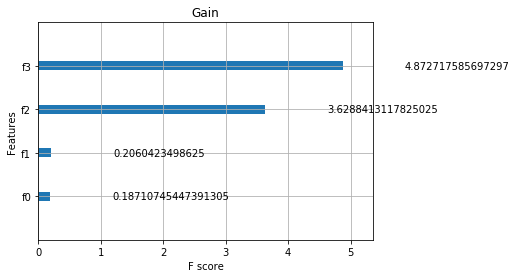

In [ ]:
plot_importance(model, importance_type='gain', title='Gain')

**Cover:** The Cover metric means the relative number of observations related to this feature. Therefore is the number of observations for which the leaf node is determined by the feature. This number will be calculated for all the features in the dataset and the cover will be expressed as a percentage over all features' cover metrics.

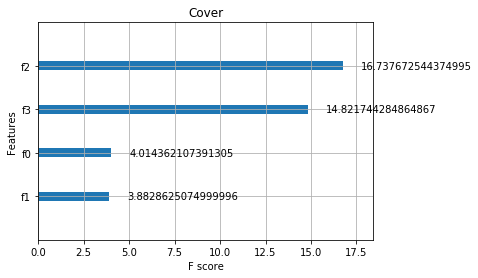

In [ ]:
plot_importance(model, importance_type='cover', title='Cover')

**Weight (Frequence):** is the percentage representing the relative number of times a particular feature occurs in the trees of the model. Is the number of splits in which the particular feature occurred.

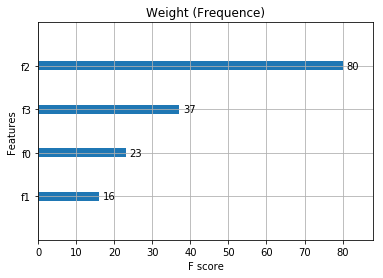

In [ ]:
plot_importance(model, importance_type='weight', title='Weight (Frequence)')